In [2]:
%load_ext autoreload
%autoreload 2

from typing import List
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

from hnlp_proj.loader import load_ynet, load_eng_test, load_ben_yehuda
from hnlp_proj.processing import FeatureType, extract_feature_lists
from hnlp_proj.utils import extract_authors, flip_hebrew_text, combine_texts, clean_texts
from hnlp_proj.plot_utils import plot_hebrew_barchart, plot_corpus_sizes, plot_feature_freqs, plot_text_length_histogram_per_author, plot_total_subcorpus_length_per_author
from hnlp_proj.delta import DeltaTransformer, combine_texts_by_author

RANDOM_STATE = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATASET_TO_PATH = {
	"ynet": "data/ynet.pickle.bz2",
	"benyehuda-articles": "data/ben_yehuda/מאמרים ומסות.pickle.bz2",
	"benyehuda-diaries": "data/ben_yehuda/זכרונות ויומנים.pickle.bz2"
}

DATASET = "benyehuda-diaries"

texts = pd.read_pickle(DATASET_TO_PATH[DATASET])
texts.head(5)

,index,ID,path,title,authors,translators,original_language,category,source_edition,text,stanza_doc
category,,,,,,,,,,,
זכרונות ויומנים,2015,2446,/p22/m2446,ירושלם החדשה,[אליעזר בן־יהודה],NaN,NaN,זכרונות ויומנים,NaN,"ירושלם החדשה\n\t\n\n\n\n1\n\nכעלות איש יהודי, ...","[[{'id': 1, 'text': '↩', 'lemma': '↩', 'upos':..."
זכרונות ויומנים,10621,18865,/p62/m18865,לחיים נחמן ביאליק,[זאב ז'בוטינסקי],NaN,NaN,זכרונות ויומנים,NaN,לחיים נחמן ביאליק\n\t\n\n\n\n\n\n\n\nלונדון ה'...,"[[{'id': 1, 'text': 'אגדת', 'lemma': 'אגדה', '..."
זכרונות ויומנים,10620,18864,/p62/m18864,לפרופסור בנימין אקצין,[זאב ז'בוטינסקי],NaN,NaN,זכרונות ויומנים,NaN,לפרופסור בנימין אקצין\n\t\n\n\n\n\n\n\n\nלודז'...,"[[{'id': 1, 'text': 'לידידי', 'lemma': 'לידידי..."
זכרונות ויומנים,10619,18863,/p62/m18863,לגנרל א. ה. ה. אלנבי,[זאב ז'בוטינסקי],NaN,NaN,זכרונות ויומנים,NaN,לגנרל א. ה. ה. אלנבי\n\t\n\n\n\n\n\n\n\nאוקטוב...,"[[{'id': 1, 'text': 'יצחק', 'lemma': 'יצחק', '..."
זכרונות ויומנים,10618,18862,/p62/m18862,"לד""ר אבא אחימאיר",[זאב ז'בוטינסקי],NaN,NaN,זכרונות ויומנים,NaN,"לד""ר אבא אחימאיר\n\t\n\n\n\nפאריס 12/11/1935\n...","[[{'id': 1, 'text': 'אמנם', 'lemma': 'אמנם', '..."


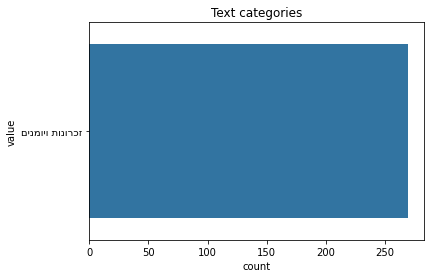

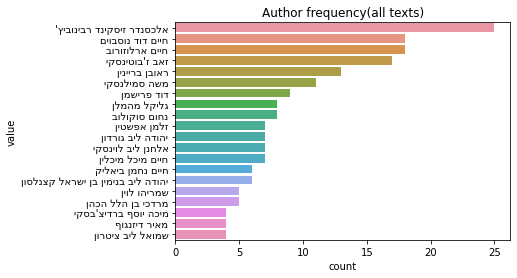

In [5]:
# Plotting frequency of categories
if "category" in texts.columns:
    plot_hebrew_barchart(texts.category, 20, title="Text categories")

# Plotting author frequency of texts
NUM_AUTHORS = 20
texts.authors = texts.authors.apply(extract_authors)
plot_hebrew_barchart(texts.authors, NUM_AUTHORS, title="Author frequency(all texts)")

# find all texts that only have 1 author
one_author_df = texts[texts.authors.str.len() == 1].copy()
one_author_df["authors"]  = one_author_df["authors"].apply(lambda ls: ls[0])
one_author_df.rename(columns={"authors": "author"}, inplace=True)

if len(one_author_df) != len(texts):
    plot_hebrew_barchart(one_author_df.author, NUM_AUTHORS, title="Author frequency(texts with only 1 author)")
    print(f"Out of {len(texts)} articles, {len(one_author_df)} of them were written by exactly 1 author")

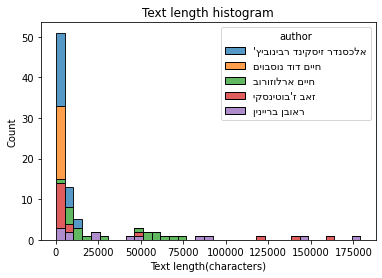

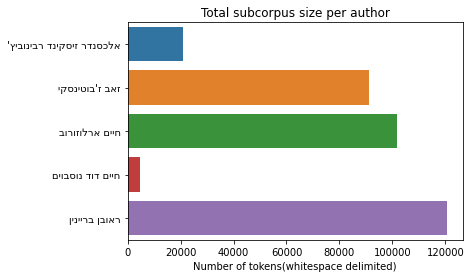

In [6]:
# choose the most prolific authors
NUM_AUTHORS = 5
chosen_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index


chosen_author_texts = one_author_df.set_index("author", drop=False).loc[chosen_authors]
chosen_author_texts

plot_text_length_histogram_per_author(chosen_author_texts)
plot_total_subcorpus_length_per_author(chosen_author_texts)


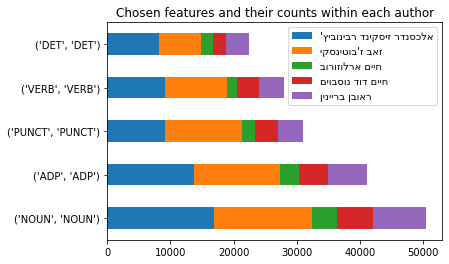

In [10]:
NUM_FEATURES = 5
PROCESSING = FeatureType.StanzaPOS

# split texts
#train, test = train_test_split(one_author_df, test_size=0.2, random_state=RANDOM_STATE, stratify=one_author_df["author"])
train, test = train_test_split(chosen_author_texts, test_size=0.2, random_state=RANDOM_STATE)

# combine X by author
train = combine_texts_by_author(train)
# train = extract_feature_lists(train, PROCESSING)




# choose features
pipeline = make_pipeline(DeltaTransformer(num_features=NUM_FEATURES, processing=PROCESSING), KNeighborsClassifier(n_neighbors=1, metric='manhattan'))

_freqs = pipeline.steps[0][1].fit_transform(train, train.index)
features = pipeline.steps[0][1].get_params()["features"]
counts = pipeline.steps[0][1].last_transformed_count
plot_feature_freqs(counts, title="Chosen features and their counts within each author")